In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# IEEE-CIS Fraud Detection Model

## 1. Project Overview
This project aims to build a robust machine learning model to detect fraudulent online transactions. Using the IEEE-CIS Fraud Detection dataset, we focus on advanced feature engineering to extract hidden patterns from anonymized and raw transaction data. The pipeline includes data preprocessing, extensive feature generation, memory optimization, and model training using LightGBM.

## 2. Dataset Description
The dataset is provided by Vesta Corporation, a leading payment service provider. It consists of two primary tables:
- **Transaction Table:** Contains transaction details like amount (`TransactionAmt`), product code (`ProductCD`), card information (`card1`-`card6`), address (`addr1`, `addr2`), email domains (`P_emaildomain`, `R_emaildomain`), and time delta (`TransactionDT`).
- **Identity Table:** Contains network and device information (IP, ISP, DeviceType, DeviceInfo, etc.) for a subset of transactions.

Key challenges include:
- **Class Imbalance:** Fraudulent transactions are a tiny fraction of the total (approx. 3.5%).
- **Anonymization:** Many features (V-columns, ID-columns) are masked, requiring statistical aggregation rather than semantic interpretation.
- **High Dimensionality:** Over 400 raw features, which we expand further through engineering.

## 3. Importance of Fraud Detection
In the digital economy, fraud detection is critical for:
- **Financial Security:** Preventing direct financial losses from chargebacks and stolen goods.
- **User Trust:** Ensuring customers feel safe transacting on the platform.
- **Operational Efficiency:** Reducing the manual review workload by automating risk scoring.

## 4. Feature Engineering Strategy
To tackle these challenges, we implement:
- **Transaction Amounts:** Log transforms, decimal extraction, and round-number flags to detect bot behavior.
- **Time:** Cyclical features (hour of day), day of week, and business hours flagging.
- **Card & Interaction:** Combining card types with locations and amounts to create unique user signatures.
- **Email Analysis:** Differentiating business vs. personal emails and checking for domain mismatches.
- **Device/Browser Fingerprinting:** Identifying specific OS/Browser combinations often used by fraud farms.
- **Aggregations:** Calculating user "velocity" (mean/std of amounts) to detect spikes in activity.
- **V-System (Vesta):** Statistical aggregation of correlated anonymous columns to reduce noise.

- **Target Variable:** `isFraud` (Binary: 0 = Legitimate, 1 = Fraud)
- **Evaluation Metric:** ROC-AUC (Area Under the Receiver Operating Characteristic Curve)
#
### Why ROC-AUC for Fraud Detection?
From a Data Science perspective, we select ROC-AUC over standard metrics like Accuracy for three critical reasons:
1.  **Robustness to Class Imbalance:** In this dataset, fraud represents only ~3.5% of cases. A trivial model predicting "Legitimate" for every transaction would achieve ~96.5% accuracy but have zero predictive power. ROC-AUC is insensitive to this imbalance, focusing instead on the model's ability to separate the signal (fraud) from the noise (legitimate).
2.  **Threshold Independence:** Unlike F1-score or Accuracy which depend on a specific classification threshold (e.g., 0.5), ROC-AUC evaluates the model's ranking ability across *all* possible thresholds. This allows business stakeholders to trade off False Positives (blocking good users) against False Negatives (missing fraud) dynamically.
3.  **Probabilistic Interpretation:** ROC-AUC represents the probability that the model ranks a randomly chosen fraudulent transaction higher than a randomly chosen legitimate one. This ranking capability is essential for prioritizing manual review queues.

## 5. Resources
- **Competition Overview:** https://www.kaggle.com/competitions/ieee-fraud-detection/overview
- **Dataset:** https://www.kaggle.com/competitions/ieee-fraud-detection/data




# 1. Import Libraries 📚

**Why these libraries?**

| Library | Purpose |
|---------|---------|
| `numpy` | Fast mathematical operations on arrays |
| `pandas` | Data manipulation and analysis (DataFrames) |
| `matplotlib` & `seaborn` | Data visualization (plots and charts) |
| `sklearn` | Machine learning tools (train/test split, metrics, encoding) |
| `lightgbm` | Gradient boosting model (fast and handles missing values well) |
| `scipy` | Statistical functions |
| `gc` | Garbage collection to free memory |

We also set `warnings.filterwarnings('ignore')` to hide unnecessary warning messages and `pd.set_option('display.max_columns', 100)` to see more columns when viewing DataFrames.

In [2]:



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import lightgbm as lgb
import warnings
import gc
import os
from scipy import stats

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


# 2. Data Loading 📂

**What we're loading:**
- `train_transaction.csv` - 590,540 transactions with 394 features (has `isFraud` target)
- `test_transaction.csv` - 506,691 transactions with 393 features (no target - we predict this)
- `train_identity.csv` - 144,233 identity records with 41 features
- `test_identity.csv` - 141,907 identity records with 41 features

**Key point:** Not all transactions have identity data! Only about 24% of transactions have matching identity information (device, browser, etc.).

In [7]:
import os
from zipfile import ZipFile

# Define data path relative to the notebook
# Getting the absolute path of the notebook's directory
NOTEBOOK_DIR = os.getcwd()
# Assuming the data directory is at the project root level, and notebook is in experiments/
# Project root is one level up from experiments/
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'raw')

# If running strictly in this notebook and paths are relative, we can try robust path finding
if not os.path.exists(DATA_DIR):
    # Fallback to local 'data' folder if project structure is different
    DATA_DIR = '../data/raw'
    if not os.path.exists(DATA_DIR):
         os.makedirs(DATA_DIR, exist_ok=True)

path = DATA_DIR
print(f"Data directory: {path}")

# Check if files exist
required_files = ['train_transaction.csv', 'test_transaction.csv', 'train_identity.csv', 'test_identity.csv']
missing_files = [f for f in required_files if not os.path.exists(os.path.join(path, f))]

if missing_files:
    print(f"Missing files: {missing_files}")
    print("Attempting to download from Kaggle...")
    
    # Helper to check for kaggle credentials
    kaggle_creds = os.path.expanduser("~/.kaggle/kaggle.json")
    if not os.path.exists(kaggle_creds):
        print("WARNING: kaggle.json not found in ~/.kaggle/. Please ensure you have API credentials set up.")
    
    # Try to install kaggle if missing
    try:
        import kaggle
    except ImportError:
        print("Installing kaggle package...")
        import subprocess
        subprocess.check_call(['pip', 'install', '-q', 'kaggle'])
        
    # Download dataset
    print("Downloading dataset...")
    import subprocess
    try:
        subprocess.check_call(['kaggle', 'competitions', 'download', '-c', 'ieee-fraud-detection', '-p', path])
        
        # Unzip
        zip_path = os.path.join(path, 'ieee-fraud-detection.zip')
        if os.path.exists(zip_path):
            print("Unzipping dataset...")
            with ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(path)
            print("Unzipped successfully.")
            # Optional cleanup
            # os.remove(zip_path)
        else:
            print("Zip file not found. Please check if download was successful.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download data: {e}")
        print("Please ensure kaggle.json is configured correctly.")

try:
    train_transaction = pd.read_csv(os.path.join(path,'train_transaction.csv'))
    test_transaction = pd.read_csv(os.path.join(path,'test_transaction.csv'))
    train_identity = pd.read_csv(os.path.join(path,'train_identity.csv'))
    test_identity = pd.read_csv(os.path.join(path,'test_identity.csv'))

    print('Data Read!')
    print(f"Shape of train_transaction: {train_transaction.shape}\nShape of test_transaction: {test_transaction.shape}\n")
    print(f"Shape of train_identity: {train_identity.shape}\nShape of test_transaction: {test_identity.shape}\n")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the data is downloaded correctly.")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/ieee-fraud-detection/train_transaction.csv'

# 3. Merge Transaction and Identity Data 🔗

**What is a LEFT JOIN?**

Think of it like this:
- Transaction table = Main guest list (everyone is invited)
- Identity table = VIP list (extra info for some guests)
- LEFT JOIN = Keep ALL guests, add VIP info where available

```
Transaction Table          Identity Table
+---------------+         +---------------+
| TransactionID |         | TransactionID |
| 100           |  LEFT   | 100 → device  |   Result: 100 gets device info
| 101           |  JOIN   | 103 → device  |   Result: 101 gets NaN (no match)
| 102           |    =    |               |   Result: 102 gets NaN
| 103           |         |               |   Result: 103 gets device info
+---------------+         +---------------+
```

**Why LEFT join instead of INNER?**
- INNER would drop transactions without identity data (~76% of data lost!)
- LEFT keeps all transactions, model can learn from missing identity patterns too

In [ ]:

# ------------------> 1


def merge_transaction_identity(train_transaction,test_transaction,train_identity,test_identity) -> tuple:
    "This function merges Transaction and indentity data using common TransactionID column as left join"

    Train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
    Test_df = test_transaction.merge(test_identity, on='TransactionID', how='left')
    
    print(f'Shape of Train_df: {Train_df.shape}\nShape of Test_df: {Test_df.shape}')
    print("Merged")
    
    
    #Free memory
    
    ## remove these vriables names from reference list
    del train_transaction,train_identity, test_transaction,test_identity
    return Train_df, Test_df


Train_df, Test_df = merge_transaction_identity(train_transaction,test_transaction,train_identity,test_identity)

Shape of Train_df: (590540, 434)
Shape of Test_df: (506691, 433)
Merged


# 4. Exploratory Data Analysis (EDA) 🔍

**What is EDA?**
EDA is like being a detective - we explore the data to understand patterns, find problems, and get insights before building a model.

**What we're looking for:**
1. **Class imbalance** - How many fraud vs non-fraud? (Important for choosing metrics)
2. **Feature distributions** - What do the numbers look like?
3. **Fraud patterns** - Which cards/emails/devices have more fraud?
4. **Missing values** - Where is data missing and why?

**First check: Target Variable Distribution**

This pie chart shows us that fraud is RARE (~3.5%). This is called **class imbalance** - it's a major challenge because:
- A dumb model saying "not fraud" for everything is 96.5% accurate!
- We need smarter metrics like ROC-AUC that aren't fooled by this

isFraud
0    569877
1     20663
Name: count, dtype: int64


<Axes: ylabel='count'>

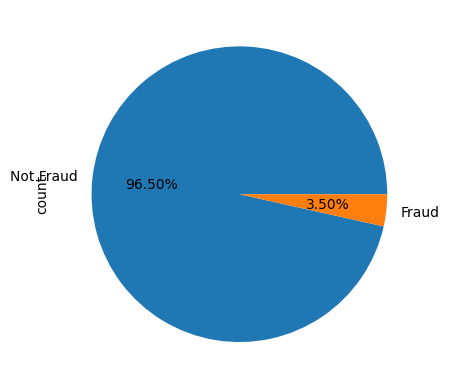

In [ ]:
# target imbalance

vc = Train_df['isFraud'].value_counts()
print(vc)

colors = sns.color_palette("pastel")
vc.plot(kind='pie', autopct='%1.2f%%', labels=['Not Fraud', 'Fraud'])

In [ ]:
Train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
(86499/3600)%24

0.027499999999999858

In [ ]:
import pandas as pd

# 1. Transaction Amount Analysis

print("--- Transaction Amount Stats (Fraud vs Normal) ---")
print(Train_df.groupby('isFraud')['TransactionAmt'].describe())
print('\n||||---->\n')

# 2. Card Type Analysis
# Grouping by Card Type first to see which specific combo is risky.
# 'mean' = Risk Percentage, 'count' = Total Volume
print("--- Fraud Rate by Card Network & Type --- count = total volume , sum= frauds")
card_stats = Train_df.groupby(['card4', 'card6'])['isFraud'].agg(['mean', 'count', 'sum'])
# Sorting by 'sum' shows where the MOST fraud happens.
# Sorting by 'mean' would show the HIGHEST RISK cards.
print(card_stats.sort_values(by='sum', ascending=False))
print('\n||||---->\n')


# 3. Email Domain Analysis
print("--- Top Risky Email Domains (by Fraud sum) ---")
email_stats = Train_df.groupby('P_emaildomain')['isFraud'].agg(['mean', 'count', 'sum'])
print(email_stats.sort_values(by='sum', ascending=False).head(10))
print('\n||||---->\n')


# 4. Device & OS Analysis
# Grouping by both to see the specific environment (e.g., Mobile Safari vs Desktop Chrome)
print("--- Top Risky Device & OS Combinations ---")
device_stats = Train_df.groupby(['id_30', 'id_31'])['isFraud'].agg(['mean', 'count', 'sum'])
print(device_stats.sort_values(by='sum', ascending=False).head(10))
print('\n||||---->\n')

--- Transaction Amount Stats (Fraud vs Normal) ---
            count        mean         std    min     25%   50%    75%  \
isFraud                                                                 
0        569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1         20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

               max  
isFraud             
0        31937.391  
1         5191.000  

||||---->

--- Fraud Rate by Card Network & Type --- count = total volume , sum= frauds
                                      mean   count   sum
card4            card6                                  
visa             debit            0.025476  301023  7669
                 credit           0.068122   83732  5704
mastercard       credit           0.069152   50772  3511
                 debit            0.021566  138415  2985
discover         credit           0.079315    6304   500
american express credit           0.028624    8175   234
discover         debit     

### Skewness Checking 📊

**What is skewness?**
Skewness measures how "lopsided" a distribution is:
- Skewness = 0 → Symmetric (like a bell curve)
- Skewness > 0 → Right-tailed (most values small, few very large)
- Skewness < 0 → Left-tailed (most values large, few very small)

**Example with TransactionAmt:**
Most transactions are small ($50-$100), but some are very large ($5000+). This creates a right-skewed distribution.

**Why check skewness?**
- For tree-based models (LightGBM, XGBoost) → Skewness is NOT a problem! Trees split on values, not distributions.
- For linear models (Logistic Regression) → High skewness CAN hurt performance.

Since we'll use LightGBM (a tree-based model), we don't need to worry about skewness, but it's good practice to check.

In [ ]:
skewed_cols = Train_df.skew(numeric_only=True).abs()
skewed_cols.head()      

TransactionID     3.024053e-16
isFraud           5.061223e+00
TransactionDT     1.311547e-01
TransactionAmt    1.437449e+01
card1             4.092898e-02
dtype: float64

# 5. Feature Engineering 🛠️

**What is Feature Engineering?**
Creating NEW columns from existing data that help the model understand patterns better.

**Why is it important?**
Raw data often doesn't clearly show fraud patterns. For example:
- `TransactionAmt = 100` tells us nothing
- `TransactionAmt = 100 AND user's average is $20` → 5x higher than normal! 🚨

**Our feature engineering categories:**
1. **Memory Reduction** - Make data smaller to process faster
2. **Transaction Amount Features** - Patterns in how much is spent
3. **Time Features** - When transactions happen
4. **Card Features** - Card usage patterns
5. **Email Features** - Email domain patterns
6. **Device Features** - Device/browser patterns
7. **Address Features** - Location patterns
8. **V-column aggregations** - Summarize anonymous features
9. **C/D column features** - Counting and time delta patterns
10. **ID features** - Identity verification patterns

## 5.1 Memory Reduction 💾

**The Problem:**
Our DataFrame uses 1,955 MB of memory. That's almost 2 GB just for training data!

**Why so much?**
By default, pandas uses:
- `int64` for integers (8 bytes per value)
- `float64` for decimals (8 bytes per value)

But most of our values don't need that precision!

**The Solution:**
Look at each column's min and max values, then choose the smallest data type:

| Original Type | Min Value | Max Value | New Type | Memory Saved |
|--------------|-----------|-----------|----------|--------------|
| int64 | -128 | 127 | int8 | 87.5% |
| int64 | -32,768 | 32,767 | int16 | 75% |
| float64 | Any small range | | float32 | 50% |

**Example:**
- `isFraud` is 0 or 1 → Only needs `int8` (1 byte) not `int64` (8 bytes)
- `card1` ranges 1-18,000 → Only needs `int16` (2 bytes) not `int64` (8 bytes)

**Result:** Memory reduced from 1,955 MB → 1,044 MB (46.6% savings!)

In [ ]:
np.iinfo(np.int16).max

32767

In [ ]:
def reduce_memory(df, verbose=True):
    start_memory = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                else:
                    df[col] = df[col].astype(np.int32)
            else:
                # Skip float16 due to compatibility issues, use float32 as minimum
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage: {start_memory:.2f} MB -> {end_mem:.2f} MB ({100 * (start_memory - end_mem) / start_memory:.1f}% reduction)')
    return df

                    
Train_df = reduce_memory(Train_df, True)
Test_df = reduce_memory(Test_df, True)

Memory usage: 1955.37 MB -> 1044.70 MB (46.6% reduction)
Memory usage: 1673.87 MB -> 895.89 MB (46.5% reduction)


## **5.2 Transaction Amount Features**

1. Log Transform: Normalizes the skewed distribution of money.
2. Decimal extraction: Fraudsters might use automated bots resulting in specific decimal patterns, or round numbers (no cents).

3. Micro Amount(testing behaviour) : Fraudsters test the account by spending small amounts


4. Sudden spike in amount
## Simple example (IEEE-CIS style)

### Raw data (unsorted)

| card_id | TransactionDT | TransactionAmt |
| ------- | ------------- | -------------- |
| A       | 200           | 100            |
| A       | 100           | 5              |
| A       | 300           | 800            |

---

### Step 3A️⃣ Sort correctly

```python
df = df.sort_values(['card_id', 'TransactionDT'])
```

After sorting:

| card_id | TransactionDT | TransactionAmt |
| ------- | ------------- | -------------- |
| A       | 100           | 5              |
| A       | 200           | 100            |
| A       | 300           | 800            |

---

### Step 3B️⃣ Create **previous amount**

```python
df['prev_amount'] = df.groupby('card_id')['TransactionAmt'].shift(1)
```

Result:

| card_id | TransactionDT | TransactionAmt | prev_amount |
| ------- | ------------- | -------------- | ----------- |
| A       | 100           | 5              | NaN         |
| A       | 200           | 100            | 5           |
| A       | 300           | 800            | 100         |

---

## Why this matters for fraud detection

Fraudsters often do:

```
₹5  → ₹100 → ₹800
(test) → (check) → (drain)
```

This feature lets your model **see the jump**.

---

## Why `shift(1)` is the key

`shift(1)` means:

* Take the **previous row after sorting**
* Push it **down by one**
* So **only past info is used**

No future leakage 🚫

---

## How the model uses it

You don’t use `prev_amount` directly — you compare it:

```python
df['amount_jump_ratio'] = df['TransactionAmt'] / (df['prev_amount'] + 1)
```

| Current | Previous | Ratio |
| ------- | -------- | ----- |
| 100     | 5        | 20 🚨 |
| 800     | 100      | 8 🚨  |
| 120     | 100      | 1.2 ✅ |

---

## Edge case (first transaction)

* First transaction per card → `prev_amount = NaN`
* This is **normal**
* You can fill with:

```python
df['prev_amount'] = df['prev_amount'].fillna(df['TransactionAmt'])
```

---

## TL;DR

* **Previous amount** = last transaction amount of the **same card**
* Sorting by `card_id + TransactionDT` is mandatory
* `shift(1)` guarantees **no data leakage**
* It helps detect **sudden jumps → fraud**


5. Rolling median
## First: what’s the problem with “previous amount”?

Using only the **last transaction** can be noisy.

Example:

```
₹5 → ₹500 → ₹10 → ₹600
```

If you compare only to the last one:

* ₹500 → ₹10 looks like a **drop**
* ₹10 → ₹600 looks like a **huge spike**

But **the user’s normal behavior** is actually around **₹500–₹600**.

So the *previous amount alone can mislead*.

---

## What is “rolling median” (in plain English)?

👉 **Rolling median = the “typical” amount the card usually spends, based on the last few transactions.**

Not the last one — but the **recent pattern**.

---

## Simple analogy 🧠

Think of:

* **Previous amount** → “What did you spend last time?”
* **Rolling median** → “What do you usually spend?”

Fraud is easier to catch when something is **far from usual**, not just far from last time.

---

## Example (last 5 transactions)

| Transaction history          | Median   |
| ---------------------------- | -------- |
| ₹450, ₹500, ₹520, ₹480, ₹510 | **₹500** |

Now:

* New transaction = ₹4,000
  ➡ Compared to **₹500**, this is clearly suspicious 🚨

---

## Why *median* and not *mean*?

Because fraud itself creates **extreme values**.

Example:

```
₹500, ₹520, ₹480, ₹450, ₹10,000
```

* Mean ≈ **₹2,158** ❌ (polluted)
* Median = **₹500** ✅ (stable)

Median ignores outliers — perfect for fraud.

---

## What the feature means

This line:

```python
amt_vs_rolling = current_amount / rolling_median_amount
```

Means:

> “How big is this transaction compared to what this card usually spends?”

---

## Why this feature is **very strong** in IEEE-CIS

* Cards have **behavior patterns**
* Fraud breaks behavior suddenly
* Rolling median captures **normal behavior**
* Ratio captures **sudden abnormality**

That’s why it often beats “previous amount”.

---

## TL;DR (one sentence)

**Rolling median = recent normal spending; fraud = sudden break from normal — comparing them makes fraud obvious.**





6. same amount repeated multiple times
7. High amount compared to user’s normal behavior

Fraud is contextual, not absolute.

₹5,000 may be normal for one user, suspicious for another.


In [ ]:
def create_transaction_amount_features(df) -> pd.DataFrame:
    """Create features based on transaction amount"""
    # Log transformation
    df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])
    
    # Decimal part extraction: often fraudsters use round numbers
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).fillna(0).astype(int)
    
    # Is round
    df['TransactionAmt_is_round'] = (df['TransactionAmt'] == df['TransactionAmt'].astype(int)).astype(int)
    
    # Amount bin: it can reduce noise by smoothing and other benefits too
    df['TransactionAmt_bins'] = pd.cut(
        df['TransactionAmt'].astype('float32'),
        bins=[0, 50, 100, 200, 500, 1000, 5000, 10_000, np.inf],
        labels=[0, 1, 2, 3, 4, 5, 6, 7]
    ).astype(float)
    
    # Value in cents
    df['TransactionAmt_cents'] = (df['TransactionAmt'] * 100 % 100).fillna(0).astype(int)
    
    # Is micro amount
    df['TransactionAmt_is_micro'] = (df['TransactionAmt'] < 10).astype(int)
    
    # Sudden amount jump
    card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
    df['card_id'] = df[card_cols].astype(str).agg('_'.join, axis=1)
    
    df = df.sort_values(['card_id', 'TransactionDT'])
    df['prev_amount'] = (
        df.groupby('card_id')['TransactionAmt']
          .shift(1)
    )
    
    df['prev_amount'] = df['prev_amount'].fillna(df['TransactionAmt'])
    df['amount_jump_ratio'] = df['TransactionAmt'] / (df['prev_amount'] + 1)
    
    df['is_amount_spike'] = (df['amount_jump_ratio'] > 5).astype(int)
    
    # Rolling mean
    df['rolling_median_amt'] = (
        df.groupby('card_id')['TransactionAmt']
          .rolling(5, min_periods=1)
          .median()
          .shift(1)
          .reset_index(level=0, drop=True)
    )
    df['rolling_median_amt'] = df['rolling_median_amt'].fillna(df['TransactionAmt'])
    df['amt_vs_rolling'] = df['TransactionAmt'] / (df['rolling_median_amt'] + 1)
    
    # Same amount repeated multiple times
    df['amt_repeat_count'] = (
        df.groupby(['card_id', 'TransactionAmt'])['TransactionAmt']
          .transform('count')
    )
    
    # High amount compared to user's normal behavior (if user_id column exists)
    if 'user_id' in df.columns:
        user_mean = df.groupby('user_id')['TransactionAmt'].transform('mean')
        user_std = df.groupby('user_id')['TransactionAmt'].transform('std')
        df['amount_zscore'] = (df['TransactionAmt'] - user_mean) / (user_std + 1)
    
    return df

Train_df = create_transaction_amount_features(Train_df)

## 5.3 Time Features ⏰

**Key insight:** Fraudsters work "off-hours" when victims are asleep!

**Why time matters:**
- Legitimate users shop during waking hours
- Fraud often happens at night (2am-5am) when no one notices
- Business transactions happen 9am-5pm weekdays

**Features we create:**

| Feature | What it captures |
|---------|------------------|
| `Transaction_hour` | Hour of day (0-23) |
| `Transaction_time_of_day` | 0=night, 1=morning, 2=afternoon, 3=evening |
| `Transaction_is_night` | 12am-6am flag (high fraud risk) |
| `Transaction_is_business_hour` | 9am-5pm flag (normal behavior) |
| `Transaction_time_gap` | Seconds since last transaction by same card |
| `Transaction_cnt_1hr` | Count of transactions in last hour (velocity) |

**Cyclic encoding - why sin/cos?**
Hours are circular: 11pm (23) is close to 1am (1), but numerically they're far (23 vs 1).

Using sin/cos:
- `hour_sin = sin(2π × hour / 24)`
- `hour_cos = cos(2π × hour / 24)`

This makes 23:00 and 01:00 appear close to the model!

In [ ]:


def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create time-based features from TransactionDT (seconds since reference time)
    """

    # -------------------------
    # Basic time decomposition
    # -------------------------

    # Hour of day (0–23) derived from seconds
    df['Transaction_hour'] = (df['TransactionDT'] // 3600) % 24

    # Seconds within a day (cyclic behavior)
    df['Transaction_sec_in_day'] = df['TransactionDT'] % 86400

    # Time of day buckets
    # 0 = night, 1 = morning, 2 = afternoon, 3 = evening
    df['Transaction_time_of_day'] = pd.cut(
        df['Transaction_hour'],
        bins=[-1, 6, 12, 18, 24],
        labels=[0, 1, 2, 3]
    ).astype(int)

    # -------------------------
    # Binary behavior flags
    # -------------------------

    # Night transactions (fraud often spikes at night)
    df['Transaction_is_night'] = (
        (df['Transaction_hour'] >= 0) & (df['Transaction_hour'] < 6)
    ).astype(int)

    # Business hours (normal human activity)
    df['Transaction_is_business_hour'] = (
        (df['Transaction_hour'] >= 9) & (df['Transaction_hour'] <= 17)
    ).astype(int)

    # -------------------------
    # Sequential time features
    # -------------------------

    # Time gap from previous transaction for the same card
    # (detects bursts / bot activity)
    df['Transaction_time_gap'] = (
        df.groupby('card_id')['TransactionDT']
          .diff()
    )

    # Fill first transaction gap with large value (no previous txn)
    df['Transaction_time_gap'] = df['Transaction_time_gap'].fillna(999999)

    # -------------------------
    # Velocity features
    # -------------------------

    # Number of transactions in last 1 hour per card
    df['Transaction_cnt_1hr'] = (
        df.groupby('card_id')['TransactionDT']
          .rolling(3600)
          .count()
          .reset_index(level=0, drop=True)
    )

    # -------------------------
    # Cyclic encoding (tree + linear friendly)
    # -------------------------

    # Sine/Cosine encoding of hour (captures cyclic nature)
    df['Transaction_hour_sin'] = np.sin(2 * np.pi * df['Transaction_hour'] / 24)
    df['Transaction_hour_cos'] = np.cos(2 * np.pi * df['Transaction_hour'] / 24)

    return df



Train_df = create_time_features(Train_df)

## 5.4 Card Features 💳

**What the card columns mean:**
- `card1` → Hashed card number (identifies the card)
- `card2` → Issuer/bank information
- `card3` → Card currency (150 = USD)
- `card4` → Network (visa, mastercard, discover, amex)
- `card5` → Card category code
- `card6` → Card type (credit, debit, charge card)

**Why combine card columns?**
A single `card1` value might be used with different addresses. Combining them creates a unique "user fingerprint":

```
card_id = card1 + card2 + card3 + card4 + card5 + card6
Example: "13926_NaN_150.0_discover_142.0_credit"
```

**Features we create:**

| Feature | Purpose |
|---------|---------|
| `card_id` | Unique card fingerprint |
| `card1_addr1` | Card + billing address (detect new locations) |
| `card1_ProductCD` | Card + product type (unusual purchases) |
| `card_id_count` | How many times card appears (high = suspicious) |
| `card_add_count` | Transactions from same address (aggregated behavior) |

**Why card + address combinations matter:**
If a card normally used in New York suddenly appears in Mumbai → 🚨 Suspicious!

In [ ]:
def create_card_features(df:pd.DataFrame) -> pd.DataFrame:
    "This func create card related features"
    print("Start creating card Features...")

    card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
    for i in card_cols:
        if i in df.columns:
            df[i]=df[i].fillna(-1).astype(str)
    #since we already created card_id with combining all cards so we dont need to make smaller combination like card1_card2 etc  but we can combine address and card

    df['card1_addrs1'] = df['card1']+ "-" + df['addr1'].fillna(0).astype(str)
    df['card1_addrs2'] = df['card1']+ "-" + df['addr2'].fillna(0).astype(str)
    df['card2_addrs1'] = df['card2']+ "-" + df['addr1'].fillna(0).astype(str)


    #maybe fraudsters can buy specific products while doing frauds
    df['card1_ProductCD'] = df[['card1','ProductCD']].ffill().astype(str).agg('_'.join, axis=1)
    df['card2_ProductCD'] = df[['card2','ProductCD']].ffill().astype(str).agg('_'.join, axis=1)

    #card uses frequency ---> not use agg('count'); but transform('count') becasue it will return one counted value for original one row
    df['card_id_count'] = df.groupby('card_id')['TransactionID'].transform('count')

    # card+ address frequency
    df['card_add_count'] = df.groupby('addr1')['TransactionID'].transform('count')

    print('Card features has been created successfully')    
    return df



Train_df = create_card_features(Train_df)

Start creating card Features...
Card features has been created successfully


## 5.5 Email Features 📧

**What the email columns mean:**
- `P_emaildomain` → Purchaser's email (person buying)
- `R_emaildomain` → Recipient's email (person receiving)

**Key fraud patterns in emails:**
1. **Unknown domains** - Rare/suspicious email providers
2. **Domain mismatch** - Purchaser ≠ Recipient (e.g., buying for "someone else")
3. **Certain providers** - Some domains have higher fraud rates (e.g., mail.com: 19%!)

**Features we create:**

| Feature | What it detects |
|---------|-----------------|
| `P_email_vendor` | Provider: google, microsoft, yahoo, apple, other |
| `email_domain_match` | P_email == R_email (1=match, 0=different) |
| `email_presence` | both_present, only_P, only_R, both_missing |
| `P_domain_count` | How common is this email domain? |
| `P_domain_fraud_rate` | Historical fraud rate for this domain (target encoding) |

**What is target encoding?**
Replace email domain with its historical fraud rate. But we use K-Fold to avoid data leakage:

```
Training fold 1 → Calculate fraud rate from folds 2-5
Training fold 2 → Calculate fraud rate from folds 1,3,4,5
... and so on
```

In [ ]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 3.9 MB/s eta 0:00:00


In [ ]:

# !pip install tldextract

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# try to use tldextract; otherwise provide a fallback extractor
try:
    import tldextract

    def extract_domain_parts(domain):
        # returns (subdomain, domain, suffix) similar to tldextract.extract
        ext = tldextract.extract(domain)
        return ext.subdomain, ext.domain, ext.suffix

except Exception:
    # lightweight fallback (not as complete as tldextract, but works for common cases)
    def extract_domain_parts(domain):
        """
        Very small fallback:
         - treats 'co.uk', 'gov.uk', 'ac.uk' as double-suffix when seen
         - returns (subdomain, domain, suffix)
        """
        if not isinstance(domain, str) or domain in ('', 'missing', 'nan'):
            return '', 'missing', ''
        domain = domain.lower().strip()
        parts = domain.split('.')
        if len(parts) == 1:
            return '', parts[0], ''
        # handle common double-suffixes
        double_suffixes = {'co.uk', 'gov.uk', 'ac.uk', 'co.jp', 'com.au', 'net.au'}
        last_two = '.'.join(parts[-2:])
        if last_two in double_suffixes:
            suffix = last_two
            dom = parts[-3] if len(parts) >= 3 else parts[-2]
            sub = '.'.join(parts[:-3]) if len(parts) > 3 else ''
            return sub, dom, suffix
        else:
            suffix = parts[-1]
            dom = parts[-2]
            sub = '.'.join(parts[:-2]) if len(parts) > 2 else ''
            return sub, dom, suffix

def create_email_features(df, target_col='isFraud', n_splits=5):
    df = df.copy()

    # normalize & fill
    for col in ['P_emaildomain', 'R_emaildomain']:
        if col in df.columns:
            df[col] = df[col].fillna('missing').astype(str).str.lower()
        else:
            df[col] = 'missing'  # ensures downstream code won't fail

    # vendor map
    vendor_map = {
        'gmail': 'google',
        'yahoo': 'yahoo',
        'hotmail': 'microsoft',
        'outlook': 'microsoft',
        'live': 'microsoft',
        'msn': 'microsoft',
        'icloud': 'apple',
        'aol': 'aol'
    }

    def get_vendor(domain):
        _, dom, _ = extract_domain_parts(domain)
        return vendor_map.get(dom, 'other')

    def get_tld(domain):
        _, _, suffix = extract_domain_parts(domain)
        return suffix if suffix else 'missing'

    # apply safely
    df['P_email_vendor'] = df['P_emaildomain'].apply(get_vendor)
    df['R_email_vendor'] = df['R_emaildomain'].apply(get_vendor)
    df['P_email_tld'] = df['P_emaildomain'].apply(get_tld)
    df['R_email_tld'] = df['R_emaildomain'].apply(get_tld)

    # match and presence
    df['email_domain_match'] = (df['P_emaildomain'] == df['R_emaildomain']).astype(int)
    df['email_presence'] = np.select(
        [
            (df['P_emaildomain'] != 'missing') & (df['R_emaildomain'] != 'missing'),
            (df['P_emaildomain'] != 'missing') & (df['R_emaildomain'] == 'missing'),
            (df['P_emaildomain'] == 'missing') & (df['R_emaildomain'] != 'missing')
        ],
        ['both_present', 'only_P', 'only_R'],
        default='both_missing'
    )

    # domain frequency: ensure TransactionID exists (if not, use index)
    id_col = 'TransactionID' if 'TransactionID' in df.columns else None
    if id_col:
        df['P_domain_count'] = df.groupby('P_emaildomain')[id_col].transform('count')
        df['R_domain_count'] = df.groupby('R_emaildomain')[id_col].transform('count')
    else:
        df['P_domain_count'] = df.groupby('P_emaildomain')['P_emaildomain'].transform('count')
        df['R_domain_count'] = df.groupby('R_emaildomain')['R_emaildomain'].transform('count')

    # K-Fold target encoding (only for P_emaildomain). Works even if target missing -> all NaNs replaced by global mean
    df['P_domain_fraud_rate'] = np.nan
    if target_col in df.columns:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_idx, val_idx in kf.split(df):
            train_df = df.iloc[train_idx]
            val_df = df.iloc[val_idx]
            mapping = train_df.groupby('P_emaildomain')[target_col].mean()
            df.loc[val_idx, 'P_domain_fraud_rate'] = val_df['P_emaildomain'].map(mapping)
        global_mean = df[target_col].mean()
        df['P_domain_fraud_rate'] = df['P_domain_fraud_rate'].fillna(global_mean)
    else:
        df['P_domain_fraud_rate'] = 0.0

    return df


Train_df = create_email_features(Train_df)

## 5.6 Device Features 📱💻

**Why devices matter for fraud:**
- Fraud farms use specific device/browser combinations
- Emulators and bots have unusual screen resolutions
- Mobile vs Desktop have different fraud patterns

**Device columns explained:**
- `DeviceType` → mobile or desktop
- `DeviceInfo` → Full device string (e.g., "SAMSUNG SM-G892A Build/NRD90M")
- `id_30` → Operating system (e.g., "Android 7.0", "iOS 11.2")
- `id_31` → Browser (e.g., "chrome 63.0", "mobile safari 11.0")
- `id_33` → Screen resolution (e.g., "2220x1080")

**Features we create:**

| Feature | What it captures |
|---------|------------------|
| `DeviceType_is_mobile` | Mobile device flag |
| `Device_brand` | Extracted brand (Samsung, Apple, etc.) |
| `DeviceInfo_length` | Long strange names = suspicious |
| `Browser_is_chrome/safari/etc` | Specific browser flags |
| `OS_is_Windows/Mac/iOS/Android` | Operating system flags |
| `Screen_width/height/area` | Resolution (unusual = emulator) |
| `Screen_aspect_ratio` | Width ÷ Height (weird ratios = bots) |

**High fraud combinations found:**
- iOS 11.2.5 + mobile safari generic → 12.7% fraud rate
- iOS 11.2.2 + mobile safari generic → 17.5% fraud rate

In [ ]:
def create_device_features(df:pd.DataFrame)->pd.DataFrame:
    print("Creating device features...")

    #device type
    df['DeviceType_is_mobile']  = (df.DeviceType == 'mobile').astype(int)
    df['DeviceType_is_desktop']  = (df.DeviceType == 'desktop').astype(int)

    #device info : it can give important patterns , we just need to specific about multiple 
    if 'DeviceInfo' in df.columns:
        df['Device_brand'] = df.DeviceInfo.apply(
            lambda x: str(x).split('/')[0].split()[0] if pd.notna(x) else 'unknown'
        )
        

        #device info length it will show device complexity even strange device could have long name
        df['DeviceInfo_length'] = df.DeviceInfo.apply(
            lambda x: len(str(x)) if pd.notna(x) else 0
        ) 


        #browser features
        if 'id_31' in df.columns:
            df['browser'] = df.id_31.apply(lambda x: str(x).split()[0].lower() if pd.notna(x) else 'unknown')
            df['Broser_is_chrome'] = df.id_31.apply(lambda x: 1 if pd.notna(x) and 'chrome' in str(x).lower() else 0)
            df['Broser_is_firefox'] = df.id_31.apply(lambda x: 1 if pd.notna(x) and 'firefox' in str(x).lower() else 0)
            df['Broser_is_edge'] = df.id_31.apply(lambda x: 1 if pd.notna(x) and 'edge' in str(x).lower() else 0)
            df['Broser_is_safari'] = df.id_31.apply(lambda x: 1 if pd.notna(x) and 'safari' in str(x).lower() else 0)


        #os features from id_30
        df[['os_name','os_version']] = df.id_30.fillna('unknown unknown').astype(str).str.split(' ',n=1,expand=True)
        
        df['OS_is_Windows'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'windows' in str(x).lower() else 0
        )
        df['OS_is_Mac'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'mac' in str(x).lower() else 0
        )
        df['OS_is_iOS'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'ios' in str(x).lower() else 0
        )
        df['OS_is_Android'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'android' in str(x).lower() else 0
        )
            
    # Screen resolution from id_33
    if 'id_33' in df.columns:
        df['Screen_width'] = df['id_33'].apply(
            lambda x: int(str(x).split('x')[0]) if pd.notna(x) and 'x' in str(x) else -1
        )
        df['Screen_height'] = df['id_33'].apply(
            lambda x: int(str(x).split('x')[1]) if pd.notna(x) and 'x' in str(x) else -1
        )
        df['Screen_area'] = df['Screen_width'] * df['Screen_height']
        df['Screen_aspect_ratio'] = df.apply(
            lambda row: row['Screen_width'] / row['Screen_height'] if row['Screen_height'] > 0 else -1, axis=1
        )

    print('Device features has been created!')
    return df

Train_df = create_device_features(Train_df)

Creating device features...
Device features has been created!


## 5.7 Address Features 🏠

**Address columns explained:**
- `addr1` → Billing region/area code
- `addr2` → Billing country code (87 = USA in most cases)
- `dist1` → Distance from card owner's location
- `dist2` → Distance from recipient's location

**Why address matters:**
- Missing addresses are suspicious (trying to hide location)
- High distances suggest card used far from home
- Address + Card combinations detect unusual usage

**Features we create:**

| Feature | Purpose |
|---------|---------|
| `addr1_addr2` | Combined location code |
| `addr1_ProductCD` | What products are bought from this region |
| `addr1_missing` | Flag for missing address (hiding?) |
| `both_addr_missing` | Both addresses missing (very suspicious) |
| `dist1_log` | Log of distance (normalizes large values) |
| `dist2_log` | Log of recipient distance |

**Example fraud pattern:**
Card registered in addr1=315 (New York) suddenly used from addr1=100 (California) with dist1=2500 miles → 🚨 Alert!

In [ ]:
def create_address_features(df):
    """Create features based on address information"""
    print("Creating address features...")
    
    # Address combinations
    if 'addr1' in df.columns and 'addr2' in df.columns:
        df['addr1_addr2'] = df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    
    # Address + ProductCD
    if 'addr1' in df.columns and 'ProductCD' in df.columns:
        df['addr1_ProductCD'] = df['addr1'].astype(str) + '_' + df['ProductCD'].astype(str)
    
    # Address distance from P_emaildomain (proxy for geographic mismatch)
    if 'addr1' in df.columns:
        df['addr1_missing'] = df['addr1'].isna().astype(int)
    
    if 'addr2' in df.columns:
        df['addr2_missing'] = df['addr2'].isna().astype(int)
    
    # Both addresses missing
    if 'addr1' in df.columns and 'addr2' in df.columns:
        df['both_addr_missing'] = (df['addr1'].isna() & df['addr2'].isna()).astype(int)
    
    # dist1 and dist2 features
    if 'dist1' in df.columns:
        df['dist1_missing'] = df['dist1'].isna().astype(int)
        df['dist1_log'] = np.log1p(df['dist1'].fillna(0))
    
    if 'dist2' in df.columns:
        df['dist2_missing'] = df['dist2'].isna().astype(int)
        df['dist2_log'] = np.log1p(df['dist2'].fillna(0))
    print('Address features has been created!')
    return df

# Apply
Train_df = create_address_features(Train_df)

Creating address features...
Address features has been created!


## 5.8 V-Column Features (Vesta Engineered) 🔐

**What are V columns?**
V1 to V339 are **ANONYMOUS** features created by Vesta Corporation. We don't know what they represent (could be counts, flags, velocities, risk scores, etc.).

**The challenge:**
339 columns of unknown meaning! How do we use them?

**Our approach: Statistical Aggregation**
Based on competition analysis, V columns have CORRELATION GROUPS (columns that move together). We aggregate each group:

| Group | Columns | What we calculate |
|-------|---------|-------------------|
| v1 | V1-V11 | sum, mean, std, nan_count |
| v2 | V12-V26 | sum, mean, std, nan_count |
| v3 | V27-V34 | sum, mean, std, nan_count |
| ... | ... | ... |
| v7 | V95-V137 | sum, mean, std, nan_count |

**Why these aggregations?**
- **Sum** → Total "magnitude" of activity
- **Mean** → Average value (normalized magnitude)
- **Std** → Variability (erratic behavior = suspicious)
- **NaN count** → Missing values (patterns in what's missing)

**Overall V statistics:**
- `V_sum_all` → Sum of ALL V columns
- `V_nan_ratio` → % of V columns that are missing

**Insight:** Fraud transactions often have MORE missing V values!

In [ ]:
def create_v_features(df):
    """Create aggregation features from V columns"""
    print("Creating V-column aggregation features...")
    
    # Get all V columns
    v_cols = [col for col in df.columns if col.startswith('V')]
    
    if len(v_cols) == 0:
        return df
    
    # Group V columns by their correlation patterns (based on EDA from competition)
    v_groups = {
        'v1': ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11'],
        'v2': ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26'],
        'v3': ['V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34'],
        'v4': ['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52'],
        'v5': ['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74'],
        'v6': ['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94'],
        'v7': ['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137'],
    }
    
    for group_name, group_cols in v_groups.items():
        # Filter to existing columns
        existing_cols = [col for col in group_cols if col in df.columns]
        
        if len(existing_cols) > 0:
            # Sum of group
            df[f'{group_name}_sum'] = df[existing_cols].sum(axis=1)
            
            # Mean of group
            df[f'{group_name}_mean'] = df[existing_cols].mean(axis=1)
            
            # Std of group
            df[f'{group_name}_std'] = df[existing_cols].std(axis=1)
            
            # NaN count in group
            df[f'{group_name}_nan_count'] = df[existing_cols].isna().sum(axis=1)
    
    # Overall V statistics
    existing_v_cols = [col for col in v_cols if col in df.columns]
    if len(existing_v_cols) > 0:
        df['V_sum_all'] = df[existing_v_cols].sum(axis=1)
        df['V_mean_all'] = df[existing_v_cols].mean(axis=1)
        df['V_std_all'] = df[existing_v_cols].std(axis=1)
        df['V_nan_count_all'] = df[existing_v_cols].isna().sum(axis=1)
        df['V_nan_ratio'] = df['V_nan_count_all'] / len(existing_v_cols)
    print("V-column aggregation features are created!")    
    return df

# Apply
Train_df = create_v_features(Train_df)


Creating V-column aggregation features...
V-column aggregation features are created!


## 5.9 C and D Column Features 📊

**What are C columns? (C1-C14)**
"C" stands for **Counting** features. They count things like:
- Number of addresses associated with this card
- Number of email addresses used
- Number of devices used
- etc. (exact meanings are anonymous)

**What are D columns? (D1-D15)**
"D" stands for **Days/Timedelta** features. They measure time since events:
- D1 = Days since first transaction
- D15 = Days since account creation
- etc. (exact meanings are anonymous)

**Key finding from competition:**
D1 and D15 are the MOST IMPORTANT D features!

**Features we create:**

For key columns (card1, card2, addr1):

| Feature | Formula | Purpose |
|---------|---------|---------|
| `{col}_freq` | Count of this value | Common cards vs rare cards |
| `{col}_TransactionAmt_mean` | Avg spending for this entity | Normal behavior baseline |
| `{col}_TransactionAmt_std` | Spending variability | Consistent vs erratic |
| `{col}_TransactionAmt_dev` | current - mean | Is THIS transaction unusual? |

**Example:**
```
card1 = 13926
card1_TransactionAmt_mean = $75
card1_TransactionAmt_std = $20
Current transaction = $500

card1_TransactionAmt_dev = $500 - $75 = $425 (21 std deviations!) 🚨
```

In [ ]:
import pandas as pd
import gc

def create_aggregation_features(train_df):
    """Create frequency and aggregation features for both train and test"""
    print("Creating aggregation features...")
    
    # 1. Create copies to avoid SettingWithCopy warnings on original dfs
    train_df = train_df.copy()
    
    # 3. Columns for frequency encoding
    freq_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
                 'ProductCD', 'DeviceType', 'DeviceInfo']
    
    for col in freq_cols:
        if col in train_df.columns:
            # Frequency encoding
            freq = train_df[col].value_counts().to_dict()
            train_df[f'{col}_freq'] = train_df[col].map(freq)
    
    # 4. Transaction amount aggregations
    # Note: 'card1_card2' must exist in df before running this
    agg_cols = ['card1', 'card2', 'addr1'] 
    
    for col in agg_cols:
        if col in train_df.columns:
            # Mean transaction amount
            agg_mean = train_df.groupby(col)['TransactionAmt'].mean().to_dict()
            train_df[f'{col}_TransactionAmt_mean'] = train_df[col].map(agg_mean)
            
            # Std transaction amount
            agg_std = train_df.groupby(col)['TransactionAmt'].std().to_dict()
            train_df[f'{col}_TransactionAmt_std'] = train_df[col].map(agg_std)
            
            # Transaction amount deviation from mean
            train_df[f'{col}_TransactionAmt_dev'] = train_df['TransactionAmt'] - train_df[f'{col}_TransactionAmt_mean']
    
    print("C and D Column Features has been implemented...")
    return train_df

# Usage: Update BOTH dataframes
Train_df= create_aggregation_features(Train_df)


Creating aggregation features...
C and D Column Features has been implemented...


In [ ]:
Train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,v2_mean,v2_std,v2_nan_count,v3_sum,v3_mean,v3_std,v3_nan_count,v4_sum,v4_mean,v4_std,v4_nan_count,v5_sum,v5_mean,v5_std,v5_nan_count,v6_sum,v6_mean,v6_std,v6_nan_count,v7_sum,v7_mean,v7_std,v7_nan_count,V_sum_all,V_mean_all,V_std_all,V_nan_count_all,V_nan_ratio,card1_freq,card2_freq,card3_freq,card4_freq,card5_freq,card6_freq,addr1_freq,addr2_freq,P_emaildomain_freq,R_emaildomain_freq,ProductCD_freq,DeviceType_freq,DeviceInfo_freq,card1_TransactionAmt_mean,card1_TransactionAmt_std,card1_TransactionAmt_dev,card2_TransactionAmt_mean,card2_TransactionAmt_std,card2_TransactionAmt_dev,addr1_TransactionAmt_mean,addr1_TransactionAmt_std,addr1_TransactionAmt_dev
182988,3169988,0,4050851,29.000000,W,10000,111.0,150.0,mastercard,117.0,debit,184.0,87.0,NaN,NaN,gmail.com,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,83.0,83.0,70.0,70.0,70.0,NaN,NaN,NaN,NaN,83.0,NaN,NaN,NaN,NaN,83.0,NaN,NaN,NaN,M0,...,0.333333,0.487950,0,0.0,0.0,0.000000,0,7.0,0.388889,0.501631,0,5.0,0.227273,0.428932,0,5.0,0.25,0.444262,0,19.0,0.44186,0.502486,0,45.000000,0.266272,0.443321,170,0.501475,1,45191,521287,189217,25941,439938,15160.0,520481.0,228355,453249,439670,NaN,NaN,29.000000,NaN,0.000000,148.895889,242.668839,-119.895889,141.490036,240.664474,-112.490036
341484,3328484,0,8421815,39.394001,C,10003,555.0,128.0,visa,226.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.458333,0.458333,0.0,NaN,7.0,7.0,0.0,0.0,NaN,NaN,NaN,M2,...,0.866667,0.351866,0,4.0,0.5,0.534522,0,18.0,1.000000,0.685994,0,21.0,0.954545,0.652998,0,15.0,0.75,0.444262,0,19.0,0.44186,0.502486,0,714.106201,2.541303,8.895429,58,0.171091,5,41995,7,384767,296546,439938,NaN,NaN,228355,57147,68519,55645.0,5.0,26.222401,14.039614,13.171600,125.703545,205.944016,-86.309544,NaN,NaN,NaN
350343,3337343,0,8634882,10.755000,C,10003,555.0,128.0,visa,226.0,debit,NaN,NaN,NaN,NaN,missing,missing,1.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,2.0,2.0,3.0,1.0,9.0,9.0,2.0,NaN,NaN,NaN,NaN,9.916666,0.916666,0.0,NaN,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.466667,0.516398,0,0.0,0.0,0.000000,0,0.0,NaN,NaN,18,21.0,0.954545,0.652998,0,0.0,NaN,NaN,20,19.0,0.44186,0.502486,0,937.328430,3.857319,14.890990,96,0.283186,5,41995,7,384767,296546,439938,NaN,NaN,94456,453249,68519,55645.0,5.0,26.222401,14.039614,-15.467401,125.703545,205.944016,-114.948545,NaN,NaN,NaN
350365,3337365,0,8635215,19.093000,C,10003,555.0,128.0,visa,226.0,debit,NaN,NaN,NaN,NaN,missing,missing,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,2.0,2.0,3.0,1.0,9.0,9.0,0.0,NaN,NaN,NaN,NaN,9.916666,0.916666,0.0,NaN,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.466667,0.516398,0,0.0,0.0,0.000000,0,0.0,NaN,NaN,18,21.0,0.954545,0.652998,0,0.0,NaN,NaN,20,19.0,0.44186,0.502486,0,1222.443604,5.030632,16.538343,96,0.283186,5,41995,7,384767,296546,439938,NaN,NaN,94456,453249,68519,55645.0,5.0,26.222401,14.039614,-7.129400,125.703545,205.944016,-106.610544,NaN,NaN,NaN
350822,3337822,0,8642405,19.093000,C,10003,555.0,128.0,visa,226.0,debit,NaN,NaN,NaN,NaN,missing,missing,1.0,5.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,4.0,2.0,2.0,4.0,1.0,10.0,10.0,0.0,NaN,NaN,NaN,NaN,139.000000,0.000000,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.466667,0.516398,0,0.0,0.0,0.000000,0,0.0,NaN,NaN,18,21.0,0.954545,0.652998,0,0.0,NaN,NaN,20,19.0,0.44186,0.502486,0,773.089600,3.181439,13.720274,96,0.283186,5,41995,7,384767,296546,439938,NaN,NaN,94456,453249,68519,85165.0,NaN,26.222401,14.039614,-7.129400,125.703545,205.944016,-106.610544,NaN,NaN,NaN


## 5.10 ID Features (Identity Verification) 🆔

**What are ID columns?**
ID features contain identity verification results from Vesta's fraud prevention system.

**ID column groups:**

| Columns | Type | Description |
|---------|------|-------------|
| id_01 to id_11 | Numerical | Verification scores/counts |
| id_12 to id_38 | Categorical | Verification results (Found/NotFound/New) |

**Key categorical features:**
- `id_12` = "Found" or "NotFound" (identity verification)
- `id_15` = "Found", "New", or "Unknown" (device recognition)
- `id_16` = "Found" or "NotFound" (matching status)
- `id_28` = "Found" or "New" (identity type)
- `id_29` = "Found" or "NotFound" (matching verification)
- `id_34` = "match_status:X" (similarity score)

**Why "New" devices are risky:**
- First-time device = no history to verify
- Fraud often uses fresh/unknown devices
- Legitimate users tend to use same devices repeatedly

**Features we create:**

| Feature | Purpose |
|---------|---------|
| `id_num_nan_count` | How many numerical IDs are missing |
| `id_num_mean/std` | Average and variability of ID scores |
| `id_15_isNew` | Flag for new/unknown device |
| `id_15_isFound` | Flag for recognized device |
| `id_34_match` | Extract match score from "match_status:X" |
| `id_36/37/38_isT` | Various T/F verification flags |

In [ ]:
def create_id_features(df):
    """Create features from identity columns"""
    print("Creating ID features...")
    
    # id_01 to id_11 are numerical
    id_num_cols = [f'id_0{i}' for i in range(1, 10)] + ['id_10', 'id_11']
    existing_id_num = [col for col in id_num_cols if col in df.columns]
    
    if len(existing_id_num) > 0:
        df['id_num_nan_count'] = df[existing_id_num].isna().sum(axis=1)
        df['id_num_mean'] = df[existing_id_num].mean(axis=1)
        df['id_num_std'] = df[existing_id_num].std(axis=1)
    
    # id_12 to id_38 are categorical
    # Check specific important ones
    if 'id_12' in df.columns:
        df['id_12_isFound'] = (df['id_12'] == 'Found').astype(int)
    
    if 'id_15' in df.columns:
        df['id_15_isNew'] = (df['id_15'] == 'New').astype(int)
        df['id_15_isFound'] = (df['id_15'] == 'Found').astype(int)
    
    if 'id_16' in df.columns:
        df['id_16_isFound'] = (df['id_16'] == 'Found').astype(int)
    
    if 'id_28' in df.columns:
        df['id_28_isNew'] = (df['id_28'] == 'New').astype(int)
        df['id_28_isFound'] = (df['id_28'] == 'Found').astype(int)
    
    if 'id_29' in df.columns:
        df['id_29_isFound'] = (df['id_29'] == 'Found').astype(int)
    
    # id_34 (match status)
    if 'id_34' in df.columns:
        df['id_34_match'] = df['id_34'].apply(
            lambda x: int(str(x).split(':')[1]) if pd.notna(x) and ':' in str(x) else -1
        )
    
    # id_36 features
    if 'id_36' in df.columns:
        df['id_36_isT'] = (df['id_36'] == 'T').astype(int)
    
    # id_37, id_38 features
    if 'id_37' in df.columns:
        df['id_37_isT'] = (df['id_37'] == 'T').astype(int)
    
    if 'id_38' in df.columns:
        df['id_38_isT'] = (df['id_38'] == 'T').astype(int)
    
    return df

# Apply
Train_df = create_id_features(Train_df)


Creating ID features...


## 5.11 Feature Engineering Summary ✅

**What we accomplished:**

| Metric | Before | After |
|--------|--------|-------|
| Number of features | 434 | 569 |
| New features created | - | 135 |
| Memory usage | 1,955 MB | 1,335 MB |
| Memory saved | - | 31% |

**Feature categories created:**

| Category | Features | Purpose |
|----------|----------|---------|
| Transaction Amount | 12 | Spending patterns, spikes, bot detection |
| Time | 9 | Night/business hours, velocity, gaps |
| Card | 6 | User fingerprints, combinations |
| Email | 8 | Domain risk, matching, providers |
| Device | 15 | Browser, OS, screen, brand |
| Address | 7 | Location patterns, distances |
| V-aggregations | 33 | Anonymous feature summaries |
| C/D aggregations | 22 | Counting and time patterns |
| ID features | 14 | Verification flags and scores |

**Next steps:**
1. Handle remaining missing values
2. Encode categorical features (Label Encoding)
3. Train LightGBM model
4. Evaluate with ROC-AUC
5. Feature importance analysis

In [ ]:
original_no_of_features = 434
new_features = Train_df.shape[1] - original_no_of_features

print(f"""

No. of Features befor Data Preprocessing: {original_no_of_features}
No. of Features after Data Preprocessing: {Train_df.shape[1]}
No. of New features created: {new_features}

----------------------------------------------------------------------------
Applying memory reduction ...

""")


Train_df = reduce_memory(Train_df)



No. of Features befor Data Preprocessing: 434
No. of Features after Data Preprocessing: 569
No. of New features created: 135

----------------------------------------------------------------------------
Applying memory reduction ...


Memory usage: 1609.37 MB -> 1335.66 MB (17.0% reduction)


# 🔥 ENHANCED FEATURE ENGINEERING (NEW - For AUC > 0.98)

## The sections below add **winning solution techniques** to boost performance:

| Technique | Description | Impact |
|-----------|-------------|--------|
| **UID Magic Features** | Create unique user IDs from card1+addr1+D1 | 🔥 HUGE |
| **UID Aggregations** | Mean/std/count per user | HIGH |
| **Time Velocity** | Time since last transaction, rapid-fire detection | HIGH |
| **Enhanced Frequency** | Normalized frequency encoding | MEDIUM |

---

## 🆕 5.12 UID Magic Features (THE KEY TO WINNING!)

**What is UID?**
UID = Unique User ID. By combining `card1 + addr1 + D1`, we can identify the SAME credit card holder across multiple transactions.

**Why is this powerful?**
- Once we know WHO is making the transaction, we can ask: "Is this unusual for THIS person?"
- Fraudsters behave differently than legitimate users - UID helps capture this!

**Example:**
```
card1=13926, addr1=315, D1=14 → UID = "13926_315_14"
All transactions with this UID are from the same card!
```

In [ ]:
# ========================================
# 🔥 NEW: UID MAGIC FEATURES
# ========================================
# This is THE most important technique from winning solutions!

def create_uid_features(train_df, test_df):
    """
    Create UID (Unique User ID) - The MAGIC feature!
    card1 + addr1 + D1 can identify unique credit card holders.
    """
    print("🔥 Creating UID magic features...")
    
    # Combine train and test for consistent encoding
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    # UID TYPE 1: card1 + addr1 (location-based)
    df['uid1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
    
    # UID TYPE 2: card1 + addr1 + D1 (time-based) - MOST POWERFUL!
    df['uid2'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['D1'].astype(str)
    
    # UID TYPE 3: Full card fingerprint
    df['uid3'] = (df['card1'].astype(str) + '_' + 
                  df['card2'].astype(str) + '_' + 
                  df['card3'].astype(str) + '_' + 
                  df['card4'].astype(str) + '_' + 
                  df['card5'].astype(str) + '_' + 
                  df['card6'].astype(str))
    
    # UID TYPE 4: card + email domain
    df['uid4'] = df['card1'].astype(str) + '_' + df['P_emaildomain'].astype(str)
    
    print(f"  ✓ uid1 unique values: {df['uid1'].nunique():,}")
    print(f"  ✓ uid2 unique values: {df['uid2'].nunique():,}")
    print(f"  ✓ uid3 unique values: {df['uid3'].nunique():,}")
    print(f"  ✓ uid4 unique values: {df['uid4'].nunique():,}")
    
    # Split back
    train_df = df[df['is_train'] == 1].drop('is_train', axis=1)
    test_df = df[df['is_train'] == 0].drop('is_train', axis=1)
    
    del df
    gc.collect()
    
    return train_df, test_df

# Apply UID features
Train_df, Test_df = create_uid_features(Train_df, Test_df)

🔥 Creating UID magic features...
  ✓ uid1 unique values: 55,370
  ✓ uid2 unique values: 410,261
  ✓ uid3 unique values: 19,810
  ✓ uid4 unique values: 62,410


## 🆕 5.13 UID-Based Aggregation Features

Now that we have UIDs, we create POWERFUL aggregated features:
- **Transaction count per user** - How active is this user?
- **Mean/Std amount per user** - What's their typical spending?
- **Amount ratio** - Is THIS transaction unusual for this user?

**Key insight:** Fraud is CONTEXTUAL. $500 may be normal for one user but suspicious for another!

In [ ]:
# ========================================
# 🔥 NEW: UID AGGREGATION FEATURES
# ========================================

def create_uid_aggregations(train_df, test_df):
    """
    Create aggregation features based on UID.
    These features capture user behavior patterns.
    """
    print("🔥 Creating UID aggregation features...")
    
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    df = df.sort_values('TransactionDT').reset_index(drop=True)
    
    uid_cols = ['uid1', 'uid2', 'uid3', 'uid4']
    
    for uid in uid_cols:
        print(f"  Processing {uid}...")
        
        # Transaction count per UID
        df[f'{uid}_count'] = df.groupby(uid)['TransactionID'].transform('count')
        
        # Transaction amount statistics
        df[f'{uid}_TransactionAmt_mean'] = df.groupby(uid)['TransactionAmt'].transform('mean')
        df[f'{uid}_TransactionAmt_std'] = df.groupby(uid)['TransactionAmt'].transform('std')
        
        # How unusual is THIS transaction for this user?
        df[f'{uid}_TransactionAmt_to_mean'] = df['TransactionAmt'] / (df[f'{uid}_TransactionAmt_mean'] + 0.001)
        df[f'{uid}_TransactionAmt_to_std'] = (df['TransactionAmt'] - df[f'{uid}_TransactionAmt_mean']) / (df[f'{uid}_TransactionAmt_std'] + 0.001)
        
        # Time-based features per UID
        df[f'{uid}_D1_mean'] = df.groupby(uid)['D1'].transform('mean')
    
    # Split back
    train_df = df[df['is_train'] == 1].drop('is_train', axis=1)
    test_df = df[df['is_train'] == 0].drop('is_train', axis=1)
    
    del df
    gc.collect()
    
    print(f"  ✓ Created {len(uid_cols) * 6} UID aggregation features")
    return train_df, test_df

Train_df, Test_df = create_uid_aggregations(Train_df, Test_df)

🔥 Creating UID aggregation features...
  Processing uid1...
  Processing uid2...
  Processing uid3...
  Processing uid4...
  ✓ Created 24 UID aggregation features


## 🆕 5.14 Time Velocity Features

**Key fraud pattern:** Fraudsters make RAPID transactions before the card gets blocked!

We create:
- **Time since last transaction** - Is this too fast?
- **Is rapid flag** - < 1 hour since last = suspicious!
- **Transaction count in session** - How many transactions in this burst?

In [ ]:
# ========================================
# 🔥 NEW: TIME VELOCITY FEATURES
# ========================================

def create_velocity_features(train_df, test_df):
    """
    Create velocity features - detects rapid-fire fraud!
    """
    print("🔥 Creating time velocity features...")
    
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    df = df.sort_values('TransactionDT').reset_index(drop=True)
    
    for uid in ['uid1', 'uid2']:
        # Time since last transaction by this user
        df[f'{uid}_time_since_last'] = df.groupby(uid)['TransactionDT'].diff()
        df[f'{uid}_time_since_last'] = df[f'{uid}_time_since_last'].fillna(999999)
        
        # Is this a rapid-fire transaction? (< 1 hour since last)
        df[f'{uid}_is_rapid'] = (df[f'{uid}_time_since_last'] < 3600).astype(int)
        
        # Transaction count in session (cumulative per user)
        df[f'{uid}_trans_in_session'] = df.groupby(uid).cumcount()
    
    # Split back
    train_df = df[df['is_train'] == 1].drop('is_train', axis=1)
    test_df = df[df['is_train'] == 0].drop('is_train', axis=1)
    
    del df
    gc.collect()
    
    print("  ✓ Created 6 velocity features")
    return train_df, test_df

Train_df, Test_df = create_velocity_features(Train_df, Test_df)

🔥 Creating time velocity features...
  ✓ Created 6 velocity features


## 🆕 5.15 Enhanced Frequency Encoding

Frequency encoding tells us: **How common is this value?**
- Rare cards/emails/devices are more suspicious
- We create both raw counts and normalized frequencies

In [ ]:
# ========================================
# 🔥 NEW: ENHANCED FREQUENCY ENCODING
# ========================================

def create_enhanced_frequency_features(train_df, test_df):
    """
    Enhanced frequency encoding with normalization
    """
    print("🔥 Creating enhanced frequency features...")
    
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    freq_cols = ['uid1', 'uid2', 'uid3', 'uid4', 
                 'card1', 'card2', 'addr1', 'P_emaildomain',
                 'DeviceType', 'DeviceInfo']
    
    for col in freq_cols:
        if col in df.columns:
            freq = df[col].value_counts()
            df[f'{col}_freq'] = df[col].map(freq)
            df[f'{col}_freq_norm'] = df[f'{col}_freq'] / len(df)
    
    # Split back
    train_df = df[df['is_train'] == 1].drop('is_train', axis=1)
    test_df = df[df['is_train'] == 0].drop('is_train', axis=1)
    
    del df
    gc.collect()
    
    print(f"  ✓ Created {len([c for c in freq_cols if c in train_df.columns]) * 2} frequency features")
    return train_df, test_df

Train_df, Test_df = create_enhanced_frequency_features(Train_df, Test_df)

🔥 Creating enhanced frequency features...
  ✓ Created 20 frequency features


## 🆕 5.16 Enhanced Feature Engineering Summary

### New Features Added:

| Category | Features | Purpose |
|----------|----------|--------|
| UID Magic | 4 UIDs | Identify unique users |
| UID Aggregations | 24 features | User behavior patterns |
| Velocity | 6 features | Rapid-fire fraud detection |
| Frequency | 20 features | How rare is each entity |

**Total new features: ~54**

---

In [ ]:
# ========================================
# ENHANCED FEATURE ENGINEERING SUMMARY
# ========================================

print("="*60)
print("🔥 ENHANCED FEATURE ENGINEERING COMPLETE!")
print("="*60)
print(f"Training set shape: {Train_df.shape}")
print(f"Test set shape: {Test_df.shape}")
print(f"\nNew UID-based features created:")
uid_features = [c for c in Train_df.columns if 'uid' in c.lower()]
print(f"  - UID features: {len(uid_features)}")
print(f"\nReady for model training with enhanced features!")

🔥 ENHANCED FEATURE ENGINEERING COMPLETE!
Training set shape: (590540, 655)
Test set shape: (506691, 655)

New UID-based features created:
  - UID features: 42

Ready for model training with enhanced features!


In [ ]:
Train_df.sample(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,id-37,id-38,uid1,uid2,uid3,uid4,uid1_count,uid1_TransactionAmt_mean,uid1_TransactionAmt_std,uid1_TransactionAmt_to_mean,uid1_TransactionAmt_to_std,uid1_D1_mean,uid2_count,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid2_TransactionAmt_to_mean,uid2_TransactionAmt_to_std,uid2_D1_mean,uid3_count,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,uid3_TransactionAmt_to_mean,uid3_TransactionAmt_to_std,uid3_D1_mean,uid4_count,uid4_TransactionAmt_mean,uid4_TransactionAmt_std,uid4_TransactionAmt_to_mean,uid4_TransactionAmt_to_std,uid4_D1_mean,uid1_time_since_last,uid1_is_rapid,uid1_trans_in_session,uid2_time_since_last,uid2_is_rapid,uid2_trans_in_session,uid1_freq,uid1_freq_norm,uid2_freq,uid2_freq_norm,uid3_freq,uid3_freq_norm,uid4_freq,uid4_freq_norm,card1_freq_norm,card2_freq_norm,addr1_freq_norm,P_emaildomain_freq_norm,DeviceType_freq_norm,DeviceInfo_freq_norm
291603,3278603,0.0,7177827,34.000000,W,1738,225.0,150.0,mastercard,117.0,debit,184.0,87.0,27.0,NaN,missing,missing,9.0,5.0,0.0,0.0,4.0,5.0,0.0,0.0,4.0,0.0,4.0,1.0,85.0,9.0,89.0,89.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,363.0,NaN,NaN,NaN,365.0,T,T,T,M1,...,NaN,NaN,1738_184.0,1738_184.0_89.0,1738_225.0_150.0_mastercard_117.0_debit,1738_missing,86,95.872093,72.972603,0.354635,-0.847870,47.197674,1,34.000000,NaN,0.999971,NaN,89.0,86,95.872093,72.972603,0.354635,-0.847870,47.197674,83,96.325302,74.118370,0.352967,-0.840877,48.710842,175412.0,0,79,999999.0,0,0,86,0.000078,1,9.113851e-07,86,0.000078,83,0.000076,0.000077,0.006785,0.024794,0.086086,NaN,NaN
589923,3576923,0.0,15798399,159.949997,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,15.0,NaN,gmail.com,missing,6.0,5.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,0.0,3.0,0.0,14.0,4.0,120.0,119.0,31.0,151.0,31.0,NaN,NaN,NaN,NaN,509.0,484.0,NaN,NaN,NaN,509.0,T,T,T,NaN,...,NaN,NaN,18018_264.0,18018_264.0_120.0,18018_452.0_150.0_mastercard_117.0_debit,18018_gmail.com,2310,116.514046,224.314301,1.372784,0.193638,108.146408,6,116.458336,55.437984,1.373441,0.784496,120.0,2770,115.682976,214.591080,1.382646,0.206284,103.455307,1336,111.306877,182.804886,1.437005,0.266092,96.025620,10485.0,0,1338,2540398.0,0,3,2310,0.002105,6,5.468311e-06,2770,0.002525,1336,0.001218,0.001430,0.001533,0.066148,0.397184,NaN,NaN
180157,3167157,0.0,3961351,34.000000,W,3166,559.0,150.0,visa,166.0,debit,204.0,87.0,NaN,NaN,missing,missing,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,142.0,NaN,NaN,NaN,NaN,142.0,NaN,NaN,NaN,M0,...,NaN,NaN,3166_204.0,3166_204.0_1.0,3166_559.0_150.0_visa_166.0_debit,3166_missing,27,90.777779,145.508682,0.374537,-0.390199,5.000000,9,114.166664,233.570389,0.297808,-0.343221,1.0,693,83.012482,96.491486,0.409572,-0.507941,116.788940,142,74.373238,92.985062,0.457148,-0.434186,83.425529,15836.0,0,8,15836.0,0,2,27,0.000025,9,8.202466e-06,693,0.000632,142,0.000129,0.000344,0.000344,0.070240,0.086086,NaN,NaN
218784,3205784,0.0,5107913,30.950001,W,6170,174.0,150.0,visa,226.0,debit,315.0,87.0,11.0,NaN,gmail.com,missing,83.0,61.0,0.0,0.0,116.0,62.0,0.0,0.0,49.0,0.0,54.0,0.0,423.0,71.0,57.0,57.0,17.0,57.0,17.0,NaN,NaN,NaN,NaN,57.0,57.0,NaN,NaN,NaN,57.0,T,T,T,NaN,...,NaN,NaN,6170_315.0,6170_315.0_57.0,6170_174.0_150.0_visa_226.0_debit,6170_gmail.com,1077,114.521942,163.061035,0.270252,-0.512516,131.348923,2,44.450001,19.091883,0.696272,-0.707070,57.0,2137,130.339630,195.935562,0.237455,-0.507254,131.473602,831,144.277908,238.608749,0.214515,-0.474951,87.157387,26437.0,0,178,999999.0,0,0,1077,0.000982,2,1.822770e-06,2137,0.001948,831,0.000757,0.000997,0.010308,0.039221,0.397184,NaN,NaN
527860,3514860,0.0,13889473,161.000000,W,17635,565.0,150.0,visa,226.0,debit,325.0,87.0,5.0,NaN,gmail.com,missing,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,33.0,2.

# **6** : Data preprocessing for The model

1. Seperate Features(X_train) and target(y_train)
2. 

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# The rest of your existing imports
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA


def local_data_preprocessor(df):
    print("Starting preprocessing...")
    
    y = df['isFraud']
    X = df.drop('isFraud', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, shuffle=True, random_state=6
    )

    # Note: select_dtypes(include=['object', 'category']) covers both string and category types
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # V columns selection
    v_cols = [c for c in X_train.columns if c.startswith('V')]
    
    # Numerical columns (Exclude V columns)
    num_cols = [c for c in X_train.select_dtypes(include=np.number).columns.tolist() if c not in v_cols]
    
    # Transformers
    num_transformer = SimpleImputer(strategy='constant', fill_value=-999)
    
    cat_transformer = OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1,
        encoded_missing_value=-999
    )

    v_pca = make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        PCA(n_components=0.96, svd_solver='full')
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols),
            ('pca', v_pca, v_cols)
        ],
        remainder='drop', # Changed to drop to be safe, or 'passthrough' if you are sure
        verbose_feature_names_out=False
    ).set_output(transform="pandas")
    
    # Apply
    # Fit on Train only
    X_train_processed = preprocessor.fit_transform(X_train)

    # using only transform to avoide data leakage
    X_test_processed = preprocessor.transform(X_test)
    
    print(f"Preprocessing complete! Train shape: {X_train_processed.shape}")

    return X_train_processed, X_test_processed, y_train, y_test

# Usage
X_train, X_test, y_train, y_test = local_data_preprocessor(Train_df)

Starting preprocessing...
Preprocessing complete! Train shape: (531486, 413)


# **7** Model Trainig :

### ok so im using LightGBM(for speed) and XGboost(robust king) so yeah let see the auc score

In [ ]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier

def train_models(X_train, X_test, y_train, y_test):

    lgbm_params = {
    'objective': 'binary',          # It's a Yes/No problem
    'metric': 'auc',                # Competition metric is ROC-AUC
    'boosting_type': 'gbdt',
    
    # --- Imbalance Handling ---
    'is_unbalance': True,           # Critical: Tells model fraud is rare
    # Alternative: 'scale_pos_weight': 9  (If you don't use is_unbalance)
    
    # --- Complexity (The most important part) ---
    'num_leaves': 256,              # High value because we have lots of data
    'min_data_in_leaf': 40,         # Stop splitting if node is too small (prevents overfitting)
    'max_depth': -1,                # No limit, let num_leaves control depth
    
    # --- Speed & Regularization ---
    'learning_rate': 0.01,          # Go slow! (Standard is 0.1, 0.01 is better for accuracy)
    'n_estimators': 2000,           # Lots of trees because learning_rate is low
    
    # --- Randomness (to prevent overfitting) ---
    'feature_fraction': 0.7,        # Use 70% of columns per tree
    'bagging_fraction': 0.7,        # Use 70% of rows per tree
    'bagging_freq': 1,              # Perform bagging every k iterations
    
    # --- Hardware ---
    'device': 'gpu',                # Use GPU if available
    'n_jobs': -1                    # Use all CPU cores
    }
    
    xgb_params = {
        # --- Core Type ---
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        
        # --- The Fix for "Invalid Input: gpu_hist" ---
        'tree_method': 'hist',      # Use 'hist' (fastest algorithm)
        'device': 'cuda',           # Enable GPU here (use 'cpu' if no GPU)
        
        # --- Imbalance Handling (Crucial for Fraud) ---
        # IEEE-CIS mein ~3.5% fraud hai. Ratio approx 27:1 hai.
        'scale_pos_weight': 27,     
        
        # --- Complexity & Overfitting ---
        'max_depth': 10,            # Thoda deep rakha hai kyuki fraud patterns complex hote hain
        'min_child_weight': 5,      # Noise kam karne ke liye (conservative setting)
        
        # --- Speed & Sampling (prevent overfitting) ---
        'learning_rate': 0.02,      # Slow learning for better accuracy
        'n_estimators': 3000,       # High number, rely on Early Stopping
        'subsample': 0.8,           # Har tree ke liye 80% data use karega
        'colsample_bytree': 0.7,    # Har split ke liye 70% features check karega
        
        # --- Regularization (L1/L2) ---
        'reg_alpha': 1,             # L1 (Lasso) - Useless features ko 0 kar deta hai
        'reg_lambda': 2             # L2 (Ridge) - Weights ko control mein rakhta hai
    }



     # XGB
    clf_xgb = XGBClassifier(**xgb_params)
    
    # Train with Monitoring
    clf_xgb.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        # Verbose=50 means "print every 50 trees"
        verbose=50 
    )
    
    # 3. See Score History After Training
    results = clf_xgb.evals_result()
    # results['validation_0']['auc'] contains the history
    print(f"Final AUC: {results['validation_1']['auc'][-1]}")
    
    # 1. Initialize
    clf_lgbm = LGBMClassifier(**lgbm_params) # Unpack your params dict
    
    # 2. Train with Monitoring
    clf_lgbm.fit(
        X_train, y_train,
        # Pass the test set here to see scores on it
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        eval_names=['Training', 'Validation'],
        eval_metric='auc',
        
        # OUTPUT CONTROL:
        # early_stopping(100): Stop if score doesn't improve for 100 rounds
        # log_evaluation(50): Print score every 50 rounds (prevents screen spam)
        callbacks=[early_stopping(stopping_rounds=100), log_evaluation(50)]
    )
    
    # 3. See Best Score After Training
    print(f"Best Iteration: {clf_lgbm.best_iteration_}")
    print(f"Best Score (Validation): {clf_lgbm.best_score_['Validation']['auc']}")



    print("Training complete!")
    return clf_lgbm,clf_xgb

In [ ]:
trained_model = train_models(X_train, X_test, y_train, y_test)

[0]	validation_0-auc:0.89975	validation_1-auc:0.86018
[50]	validation_0-auc:0.95533	validation_1-auc:0.92700
[100]	validation_0-auc:0.96821	validation_1-auc:0.93851
[150]	validation_0-auc:0.97785	validation_1-auc:0.94642
[200]	validation_0-auc:0.98368	validation_1-auc:0.95136
[250]	validation_0-auc:0.98778	validation_1-auc:0.95549
[300]	validation_0-auc:0.99068	validation_1-auc:0.95799
[350]	validation_0-auc:0.99295	validation_1-auc:0.95984
[400]	validation_0-auc:0.99462	validation_1-auc:0.96160
[450]	validation_0-auc:0.99596	validation_1-auc:0.96316
[500]	validation_0-auc:0.99693	validation_1-auc:0.96445
[550]	validation_0-auc:0.99767	validation_1-auc:0.96562
[600]	validation_0-auc:0.99825	validation_1-auc:0.96667
[650]	validation_0-auc:0.99868	validation_1-auc:0.96740
[700]	validation_0-auc:0.99899	validation_1-auc:0.96789
[750]	validation_0-auc:0.99924	validation_1-auc:0.96859
[800]	validation_0-auc:0.99942	validation_1-auc:0.96894
[850]	validation_0-auc:0.99957	validation_1-auc:0.9

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 250 dense feature groups (127.73 MB) transferred to GPU in 0.131362 secs. 1 sparse feature groups
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034829 -> initscore=-3.321862
[LightGBM] [Info] Start training from score -3.321862
Training until validation scores don't improve for 100 rounds
[50]	Training's auc: 0.966955	Validation's auc: 0.934876
[100]	Training's auc: 0.974386	Validation's auc: 0.940206
[150]	

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


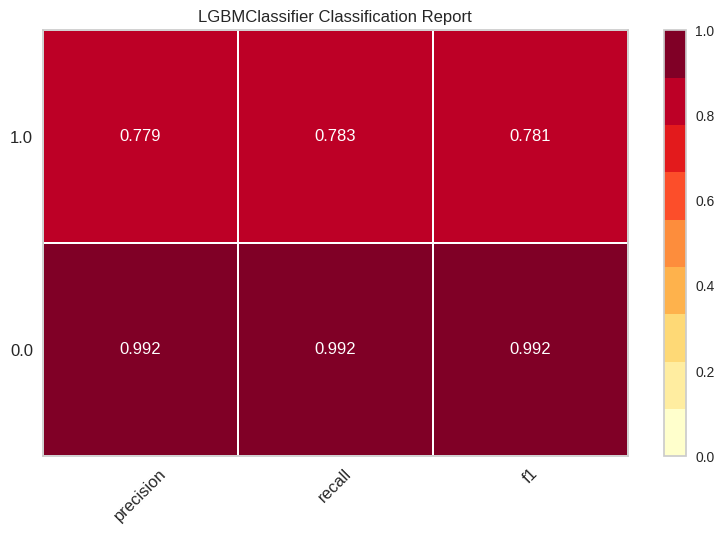

<Axes: title={'center': 'LGBMClassifier Classification Report'}>

In [ ]:
from yellowbrick.classifier import ClassificationReport

class_names = np.unique(y_test).astype(str)
viz = ClassificationReport(trained_model[0], classes=class_names)

viz.score(X_test, y_test)   # uses model.predict internally
viz.show()


In [5]:
from yellowbrick.classifier import ClassificationReport

class_names = np.unique(y_test).astype(str)
viz = ClassificationReport(trained_model[1], classes=class_names)

viz.score(X_test, y_test)   # uses model.predict internally
viz.show()

NameError: name 'y_test' is not defined

# **Experiment Tracking using MLflow**

In [4]:
%pip install mlflow dagshub catboost xgboost lightgbma


ERROR: Could not find a version that satisfies the requirement lightgbma (from versions: none)
ERROR: No matching distribution found for lightgbma


In [ ]:
import dagshub  
import mlflow


mlflow.set_tracking_uri('https://dagshub.com/santosh4thmarch/IEEE-CIS-Fraud-detection.mlflow')
dagshub.init(repo_owner='santosh4thmarch', repo_name='IEEE-CIS-Fraud-detection',mlflow=True)

In [ ]:
import mlflow
import mlflow.sklearn
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, roc_auc_score, accuracy_score



#defining mdoel configurations, model_name: params


model_config = {
    "xgboost":{
        "model_class":XGBClassifier,
        "params":{
            
        }
    }
}